#  Calculation Method Outlier Prevalence

Below we attempt to ascertain if possible which calcualtion method was used to produce the 'Scope 3 Amount' for each 'Scope 3 Sources' type.  We then take the z-scores of each 'Scope 3 Amount' and find the percentage of outliers for each calculation method group.





In [13]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import squarify
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

# Import data

First we import the data from a csva and create a datatype dictionary.  Here we also have the Scope 1 and 2 data even it is not actually used. 

In [16]:
path_Scope_3_df = r"C:\Users\cliff\Downloads\Scope_3_df.csv"

dtype_dict = {
    "Year of Data": str,
    "Primary activity": str,
    "Primary sector": str,
    "Primary industry": str,
    "Account Numbers": str,
    "Countries": str,
    "Company Name": str,
    "Primary Stock Ticker": str,
    "Row_num": str,
    "Scope 3 Sources": str,
    "Evaluation Status": str,
    "Calculation Methodology": str,
    "Explanation": str,
    "Scope 3 Amount": float,
    "Perc emissions calculated w primary data": float,
    "Scope 1 2 total emission": float,
    "Scope 1 2 max": float,
    "Scope 1 2 Normalized": float,
    "Scope 3 max": float,
    "Scope 3 estimate": float,
    "Scope 3 Amount or Estimate": float
}

columns_to_drop = ['Scope 1 2 max', 'Scope 1 2 Normalized', 'Scope 3 max', 'Scope 3 estimate', 'Scope 3 Amount or Estimate']


Scope_3_df = pd.read_csv(path_Scope_3_df, dtype=dtype_dict, low_memory=False)

Scope_3_df = Scope_3_df.drop(columns=columns_to_drop)

In [17]:
print(f"Scope_3_df shape: {Scope_3_df.shape}")
Scope_3_df.head()

Scope_3_df shape: (914339, 16)


,Year of Data,Primary activity,Primary sector,Primary industry,Account Numbers,Countries,Company Name,Primary Stock Ticker,Row_num,Scope 3 Sources,Evaluation Status,Scope 3 Amount,Calculation Methodology,Perc emissions calculated w primary data,Explanation,Scope 1 2 total emission
0,2013,Asset managers,Financial services,Services,44,United Kingdom,3i Group,III LN,1,Purchased goods and services,Not evaluated,NaN,NaN,NaN,We do not have access to this data at this point in time. We are working towards evaluating Scope 3 emnissions for this category in the future.,406.35
1,2013,Asset managers,Financial services,Services,44,United Kingdom,3i Group,III LN,2,Capital goods,Not evaluated,NaN,NaN,NaN,We do not have access to this data at this point in time. We are working towards evaluating Scope 3 emnissions for this category in the future.,406.35
2,2013,Asset managers,Financial services,Services,44,United Kingdom,3i Group,III LN,3,Fuel-and-energy-related activities (not included in Scope 1 or 2),"Not relevant, explanation provided",0.00,NaN,NaN,We do not have any fuel or energy related activities beyond that declared in Scope 1 and 2 activities.,406.35
3,2013,Asset managers,Financial services,Services,44,United Kingdom,3i Group,III LN,4,Upstream transportation and distribution,"Not relevant, explanation provided",0.00,NaN,NaN,NaN,406.35
4,2013,Asset managers,Financial services,Services,44,United Kingdom,3i Group,III LN,5,Waste generated in operations,"Relevant, calculated",12.34,Defra 2012,NaN,NaN,406.35


# Calculation Methodology

First getting an idea of how many unique values are in the 'Calculation Methodology' column.

In [19]:
unique_count = Scope_3_df["Calculation Methodology"].nunique()
print("Number of unique values in 'Calculation Methodology':", unique_count)


Number of unique values in 'Calculation Methodology': 76945


# Determine Calculation Methods

Initially, I attempted to use text analytics methods to categorize the different types of calculations; however, this approach proved ineffective. Instead, manually reviewing the various values and extracting relevant terms yielded a significantly greater number of distinct calculation methods. Some methods are explicitly stated (e.g., "Average Data Method", "GHG Conversion"), while others share common terminology indicating how the calculations were performed (e.g., "Partially calculated", "Extrapolated").

The script below filters out rows containing any of the specified terms_to_filter, retaining only those that do not fall under any predefined category. These remaining rows are labeled as "Calculation Undetermined." As a result, from the original dataset of 914,000 rows, 9,655 rows remain without an attributable calculation method.

Additionally, some methods and explanations are in foreign languages making it harder to ascertain the method used. I attempted to auto translate these but that was ineffective so most of these remain in the 'Calculation Undetermined' category.

In [23]:
import re
import pandas as pd

# Example list of terms to filter out (add more terms as needed)
terms_to_filter = [
    'PAS 2050','BILAN CARBONE', 'business air travel', ' air travel', 'Greenhouse Gas Inventory Protocol', 'multiply ', 'sampling strategy', 'directly from suppliers', 'mileage', 'not possible','Input Output', 'TCR' ,
    '=', 'TCFD', 'Carbon Footprint calculation', 'Defra', 'None', 'input-output', 'sales quantities', '3rd parti', 'commercial flights', 'transport costs', 'Calculation method: ',
    'Spend-Based', 'Waste-Type', 'Average-Data Method',
    'Distance-Based Method',  'Greenhouse Gas Protocol',
     'ISO 14', 'Corporate Value Chain',
    'World Business Council',  
    'Included in Scope 1 and Scope 2 Emissions', 'Not applicable', 'Not evaluated', 'Currently under evaluation',
    'National emission factors', 'not measured', 'not relevant', 'Fuel-based method',
    'Average data method', 'Asset-specific method', 'Franchise-specific method',
    'Supplier-specific method', 'Average product method', 'Hybrid method', 'Lessor-specific method',
    'Site-specific method', 'Other', 'Investment-specific method', 'indirect use',
    'direct use', 'International Civil Aviation Organization',
    'IPCC', 'WRI transport', 'GHG protocol',
    'Greenhouse Gas (GHG) Protocol Corporate Accounting and Reporting Standard', 
    'EPA Waste Reduction Model', 
    'HBEFA', 'estimate', 'consumption data', 
    'Life Cycle Assessment', 'SmartWay', 'National Greenhouse Accounts',
     'employee survey', 
    'Trucost', 'Emissions Unit Database', 'Greenhouse Gas (GHG) Protocol',
    'EcoInvent database', 'LCA database', 'proprietary tool', 'Activity data',
    'extrapolat', 'statistical data',
    'Product Category Rule', 'assum', 'air miles', 'travel agenc',
    'EIO LCA Tool', 'Distance based', 'Generic data', 'emission factor',
    'ADEME', 'Emissions factor', 'WARM', 'GHG Conversion', 
    'Ecoinvent', 'GaBi database', 
    'Greenhouse Gas Inventory Protocol Core Module Guidance', 'GHG Emission Factors Hub',
     'Waste from operations', 'Partially calculated', 'climas'
]

# Escape each term to ensure any special regex characters are treated literally
escaped_terms = [re.escape(term) for term in terms_to_filter]
pattern = '|'.join(escaped_terms)

# Pre-compile the regex pattern with IGNORECASE flag
compiled_pattern = re.compile(pattern, flags=re.IGNORECASE)

# Vectorized filtering on Scope_3_df:
# 1. "Calculation Methodology" must not be null and must not contain any unwanted terms.
# 2. "Scope 3 Amount" must not be null and must be >= 10000.
# 3. "Explanation" must not contain any unwanted terms.
filtered_df = Scope_3_df[
    Scope_3_df["Calculation Methodology"].notna() &
    ~Scope_3_df["Calculation Methodology"].str.contains(compiled_pattern, na=False) &
    Scope_3_df["Scope 3 Amount"].notna() &
    (Scope_3_df["Scope 3 Amount"] >= 10000) &
    ~Scope_3_df["Explanation"].str.contains(compiled_pattern, na=False)
]

print("Filtered DataFrame shape:", filtered_df.shape)
filtered_df.head(50)


Filtered DataFrame shape: (9653, 16)


,Year of Data,Primary activity,Primary sector,Primary industry,Account Numbers,Countries,Company Name,Primary Stock Ticker,Row_num,Scope 3 Sources,Evaluation Status,Scope 3 Amount,Calculation Methodology,Perc emissions calculated w primary data,Explanation,Scope 1 2 total emission
96,2013,Medical equipment,Medical equipment & supplies,"Biotech, health care & pharma",64,USA,Abbott Laboratories,ABT US,12,Use of sold products,"Not relevant, calculated",31000.0,Sustainability Consortium Open IO Life Cycle tool which uses estimations for Abbott's main product sectors.,0.0,NaN,1.055384e+06
97,2013,Medical equipment,Medical equipment & supplies,"Biotech, health care & pharma",64,USA,Abbott Laboratories,ABT US,13,End of life treatment of sold products,"Not relevant, calculated",16000.0,Sustainability Consortium Open IO Life Cycle tool which uses estimations for Abbott's main product sectors.,0.0,NaN,1.055384e+06
138,2013,CCGT generation,Thermal power generation,Power generation,87,Italy,A2A,A2A IM,3,Fuel-and-energy-related activities (not included in Scope 1 or 2),"Relevant, calculated",727123.0,calculation of fuel and energy contribution to CO2 emissions of the considered plants with same metodology as for scope 1 and 2,NaN,management of a third parties wte plant and of about 2000 heating and air-conditioning plants (energy management services),5.226526e+06
242,2013,Hotels & lodging,"Bars, hotels & restaurants",Hospitality,156,France,AccorHotels,AC FP,5,Waste generated in operations,"Relevant, calculated",75800.0,"i) Types and sources of data : waste managementSources: Internal audit by Accor in order to characterize the waste generated in six specific hotels.ii) Data quality : lowiii) Methodology, explanation :From the data collected in the studies the quantities of wastes produced per room are determined according to the segment of the hotel and the typologies of waste. From this characterization, modeling is made using the Wisard database to evaluate the impacts of the wastes generated in one room during one year according to the segment of the hotel and the types of treatment.",NaN,NaN,1.292257e+06
253,2013,Hotels & lodging,"Bars, hotels & restaurants",Hospitality,156,France,AccorHotels,AC FP,16,Other (upstream),"Relevant, calculated",165000.0,"i) Types and sources of data : Construction and renovation Source : CIMbéton study named ""Environment, quality of buildings"" (October 2009)ii) Data quality : averageiii) Methodology, explanation :The medthodology only focused on the building solution itself and excluded the additional activities (external parking, recreational areas – swimming pool, Spa, fitness). This exclusion is mainly due to a lack of information.The methodology covered the 5 following parts : infrastructure, superstructure, coverage, carpentry, work inside.Results : 382 kg eq. CO2/m²",NaN,NaN,1.292257e+06
278,2013,Transportation support services,Industrial support services,Services,173,France,ADP (Aeroports de Paris),ADP FP,7,Employee commuting,"Relevant, calculated",605867.0,we take into account the movement of passengers and employees to get to the airport,29.0,NaN,1.632240e+05
460,2013,"Supermarkets, food & drugstores",Convenience retail,Retail,258,Japan,"Aeon Co., Ltd.",8267 JP,2,Capital goods,"Relevant, calculated",1036588.0,イオン㈱設備投資額は、ＩＲ発表資料より、3263億80百万円。 排出係数は「サプライチェーンを通じた組織の温室効果ガス排出等の算定のための排出原単位データベース（ｖｅｒ．2.0）」を利用。,100.0,NaN,3.564513e+06
461,2013,"Supermarkets, food & drugstores",Convenience retail,Retail,258,Japan,"Aeon Co., Ltd.",8267 JP,3,Fuel-and-energy-related activities (not included in Scope 1 or 2),"Relevant, calculated",4540237.0,スコープ1、２の温室効果ガス排出量実績値を基に算定。排出係数は「サプライチェーンを通じた組織の温室効果ガス排出等の算定のための排出原単位データベース（ｖｅｒ．2.0）」を利用。,100.0,NaN,3.564513e+06
462,2013,"Supermarkets, food & drugstores",Convenience retail,Retail,258,Japan,"Aeon Co., Ltd.",8267 JP,4,Upstream transportation and distribution,"Relevant, calculated",210000.0,幹線物流（店舗配送用倉庫までの拠点センター間の物流）と店配送物流（店舗配達用倉庫～店まで）の物流について以下のように集計。幹線物流の算定：計算式は重量に輸送距離を乗じて集

#  Prevalence of Method

Below I've used the same terms but printing out how many rows each method accounts for.  The idea is to eliminate methods that pertain only to one or two companies as they would not be widespread enough to count as a major effort.  More methods were originally found than those listed below but were eliminated due to low useage numbers.

In [27]:
import re
import pandas as pd


terms_to_filter = [
    'annual report', 'PAS 2050', 'BILAN CARBONE', 'business air travel', ' air travel', 'Greenhouse Gas Inventory Protocol', 'multiply ', 'sampling strategy', 'directly from suppliers', 'mileage', 'not possible','Input Output', 'TCR' ,
    '=', 'TCFD', 'Carbon Footprint calculation', 'Defra', 'None', 'input-output', 'sales quantities', '3rd parti', 'commercial flights', 'transport costs', 'Calculation method: ',
    'Spend-Based', 'Waste-Type', 'Average-Data Method',
    'Distance-Based Method',  'Greenhouse Gas Protocol',
     'ISO 14', 'Corporate Value Chain',
    'World Business Council',  
    'Included in Scope 1 and Scope 2 Emissions', 'Not applicable', 'Not evaluated', 'Currently under evaluation',
    'National emission factors', 'not measured', 'not relevant', 'Fuel-based method',
    'Average-data method', 'Asset-specific method', 'Franchise-specific method',
    'Supplier-specific method', 'Average product method', 'Hybrid method', 'Lessor-specific method',
    'Site-specific method', 'Other', 'Investment-specific method', 'indirect use',
    'direct use', 'International Civil Aviation Organization',
    'IPCC', 'WRI transport', 'GHG protocol',
    'Greenhouse Gas (GHG) Protocol Corporate Accounting and Reporting Standard', 
    'EPA Waste Reduction Model', 
    'HBEFA', 'estimate', 'consumption data', 
    'Life Cycle Assessment', 'SmartWay', 'National Greenhouse Accounts',
     'employee survey', 
    'Trucost', 'Emissions Unit Database', 'Greenhouse Gas (GHG) Protocol',
    'EcoInvent database', 'LCA database', 'proprietary tool', 'Activity data',
    'extrapolat', 'statistical data',
    'Product Category Rule', 'assum', 'air miles', 'travel agenc',
    'EIO LCA Tool', 'Distance based', 'Generic data', 'emission factor',
    'ADEME', 'Emissions factor', 'WARM', 'GHG Conversion', 
    'Ecoinvent', 'GaBi database', 
    'Greenhouse Gas Inventory Protocol Core Module Guidance', 'GHG Emission Factors Hub',
     'Waste from operations', 'Partially calculated',
]



# For each term, count the rows that contain that term in "Calculation Methodology" or "Explanation"
print("Row deletion counts per term:")
for term in terms_to_filter:
    # Escape term and compile a case-insensitive regex for that specific term
    regex_term = re.compile(re.escape(term), flags=re.IGNORECASE)
    count = (
        Scope_3_df["Calculation Methodology"].str.contains(regex_term, na=False).sum() +
        Scope_3_df["Explanation"].str.contains(regex_term, na=False).sum()
    )
    print(f"{term}: {count} rows")



# Escape each term and join to create one pattern
escaped_terms = [re.escape(term) for term in terms_to_filter]
pattern = '|'.join(escaped_terms)

# Pre-compile the regex pattern with IGNORECASE flag
compiled_pattern = re.compile(pattern, flags=re.IGNORECASE)

# Filter out rows where:
# - "Calculation Methodology" is null OR contains any of the unwanted terms.
# - "Explanation" contains any of the unwanted terms.
# - "Scope 3 Amount" is null OR is less than 10000.
filtered_df = Scope_3_df[
    Scope_3_df["Calculation Methodology"].notna() &
    ~Scope_3_df["Calculation Methodology"].str.contains(compiled_pattern, na=False) &
    Scope_3_df["Scope 3 Amount"].notna() &
    (Scope_3_df["Scope 3 Amount"] >= 100) &
    ~Scope_3_df["Explanation"].str.contains(compiled_pattern, na=False)
]

print("Filtered DataFrame shape:", filtered_df.shape)
filtered_df.tail(50)


Row deletion counts per term:
annual report: 1856 rows
PAS 2050: 526 rows
BILAN CARBONE: 2209 rows
business air travel: 819 rows
 air travel: 6831 rows
Greenhouse Gas Inventory Protocol: 203 rows
multiply : 1403 rows
sampling strategy: 35 rows
directly from suppliers: 286 rows
mileage: 4558 rows
not possible: 958 rows
Input Output: 1367 rows
TCR: 90 rows
=: 10389 rows
TCFD: 134 rows
Carbon Footprint calculation: 633 rows
Defra: 21152 rows
None: 2028 rows
input-output: 3042 rows
sales quantities: 54 rows
3rd parti: 189 rows
commercial flights: 81 rows
transport costs: 57 rows
Calculation method: : 753 rows
Spend-Based: 18059 rows
Waste-Type: 6465 rows
Average-Data Method: 1030 rows
Distance-Based Method: 15758 rows
Greenhouse Gas Protocol: 8073 rows
ISO 14: 4512 rows
Corporate Value Chain: 12176 rows
World Business Council: 984 rows
Included in Scope 1 and Scope 2 Emissions: 149 rows
Not applicable: 479979 rows
Not evaluated: 2699 rows
Currently under evaluation: 29 rows
National emissi

,Year of Data,Primary activity,Primary sector,Primary industry,Account Numbers,Countries,Company Name,Primary Stock Ticker,Row_num,Scope 3 Sources,Evaluation Status,Scope 3 Amount,Calculation Methodology,Perc emissions calculated w primary data,Explanation,Scope 1 2 total emission
890947,2022,IT services,IT & software development,Services,871519,USA,Reaktor,NaN,1,Purchased goods and services,"Relevant, calculated",5.950000e+02,Average data method,66.0,"Emissions from business travel are currently responsible for 9% of total emissions and this category was the fourth largest source of emissions during 2020. The emissions from flights have decreased sharply since the previous year, mainly due to Covid-19. Even so, Reaktor can take measures to keep the number of flights low and preferably even decrease them further. Reaktor could set a specific reduction target on flight travel, or roll out an internal carbon price mechanism based on flight travel. Where possible, meetings could be held virtually, building on best practices during Covid-19.",NaN
890953,2022,IT services,IT & software development,Services,871519,USA,Reaktor,NaN,7,Employee commuting,"Relevant, calculated",1.550000e+02,Average data method,17.0,NaN,NaN
891850,2022,Specialty chemicals,Chemicals,Materials,872581,China,CONNELL CHEMICAL INDUSTRY LIMITED LIABILITY COMPANY,NaN,3,Fuel-and-energy-related activities (not included in Scope 1 or 2),"Relevant, calculated",1.051110e+06,Average data method,38.91,NaN,1.051110e+06
892786,2022,Fabricated metal components,Metal products manufacturing,Manufacturing,873817,Portugal,MD Group SA,NaN,4,Upstream transportation and distribution,"Relevant, calculated",4.890000e+02,Average data method,10.0,NaN,1.552000e+03
892791,2022,Fabricated metal components,Metal products manufacturing,Manufacturing,873817,Portugal,MD Group SA,NaN,9,Downstream transportation and distribution,"Relevant, calculated",6.180000e+02,Average data method,70.0,NaN,1.552000e+03
892817,2022,Fabricated metal components,Metal products manufacturing,Manufacturing,873844,China,li kunli,NaN,1,Purchased goods and services,"Relevant, calculated",2.432460e+03,Average data method,9.7,由供应商产出和能耗的平均数据计算而来。,NaN
892820,2022,Fabricated metal components,Metal products manufacturing,Manufacturing,873844,China,li kunli,NaN,4,Upstream transportation and distribution,"Relevant, calculated",2.432460e+03,Average data method,9.7,供应商熔炼消耗,NaN
900300,2022,Energy infrastructure construction,Construction,Infrastructure,880411,Netherlands,Van den Heuvel Aannemingsbedrijf B.V.,NaN,4,Upstream transportation and distribution,"Relevant, calculated",1.340000e+02,Average data method,0.0,NaN,3.963000e+03
900524,2022,Other professional services,Specialized professional services,Services,880513,Canada,IFG - INTERNATIONAL FINANCIAL GROUP LTD,NaN,7,Employee commuting,"Relevant, calculated",2.125000e+02,Average data method,0.0,"This is an approximation. Not all IFG staff members and outsourced employees commute to a physical office for the full work week. A majority of staff members and outsourced employees work virtually from home. Staff members and outsourced employees that do operate on a hybrid week, half in the office and half at home.",3.373150e+02
900525,2022,Other professional services,Specialized professional services,Services,880513,Canada,IFG - INTERNATIONAL FINANCIAL GROUP LTD,NaN,8,Upstream leased assets,"Relevant, calculated",4.374700e+02,Average data method,0.0,NaN,3.373150e+02


# Adding Methods

Below we use the same methodology but instead of eliminating rows we assign the calculation method(s) found to a new column.  Some rows will fall under multiple methods depending on terms found but that will be dealt with using the explode function to ungroup by comma separation.

The terms_mapping will combine certain categories that are similar enough but spelled/presented differently.

Also below we calculate the Scope 3 amount Z score for later useage.

In [104]:
import re
import pandas as pd
from scipy.stats import zscore

# Define category mapping for merging similar terms
term_mapping = {
    "Equals": ['=', ' = '],
    "Input Output": ["Input Output", "input-output"],
    "Greenhouse Gas Protocol": [
        "Greenhouse Gas Protocol", 
        "Greenhouse Gas (GHG) Protocol Corporate Accounting and Reporting Standard",
        "Greenhouse Gas (GHG) Protocol",
        "Greenhouse Gas Inventory Protocol"
    ],
    "Asset Specific Method": ["Lessor-specific method", "Asset-specific method", "Asset specific method"],
    "Direct Use": ["direct use", "direct-use"],
    "indirect use": ["indirect use", "indirect-use"],
    "3rd Parties": ['3rd parti', 'third party', '3rd parties']
}

# Flatten the dictionary into a mapping of individual terms to their standardized category
flattened_mapping = {term: category for category, terms in term_mapping.items() for term in terms}

# Expanded list of terms to filter
terms_to_filter = [
    'PAS 2050', 'BILAN CARBONE', 'air travel','multiply ', 'sampling strategy', 'directly from suppliers',
    'multiply ', 'sampling strategy', 'directly from suppliers', 'mileage', 'not possible',
    'TCR', 'EPA guidance', 'TCFD', 'Carbon Footprint calculation', 'Defra', 'None', 
    'sales quantities', 'commercial flights', 'transport costs', 'Calculation method: ',
    'Spend-Based', 'Waste-Type', 'Average-Data Method', 'Distance-Based Method', 
    'ISO 14', 'Corporate Value Chain', 'World Business Council',  
    'Included in Scope 1 and Scope 2 Emissions', 'Not applicable', 'Not evaluated', 
    'Currently under evaluation', 'National emission factors', 'not measured', 'not relevant', 
    'Fuel-based method', 'Average data method', 'Franchise-specific method',
    'Supplier-specific method', 'Average product method', 'Hybrid method', 'Lessor-specific method',
    'Site-specific method', 'Other', 'Investment-specific method', 
     'International Civil Aviation Organization', 'IPCC', 'WRI transport', 
    'EPA Waste Reduction Model', 'HBEFA', 'estimate', 'consumption data', 
    'Life Cycle Assessment', 'SmartWay', 'National Greenhouse Accounts', 'employee survey', 
    'Trucost', 'Emissions Unit Database', 'EcoInvent database', 'LCA database', 'proprietary tool', 
    'Activity data', 'extrapolat', 'statistical data', 'Product Category Rule', 'assum', 'air miles', 
    'travel agenc', 'EIO LCA Tool', 'Distance based', 'Generic data', 'emission factor',
    'ADEME', 'Emissions factor', 'WARM', 'GHG Conversion', 'Ecoinvent', 'GaBi database', 
    'GHG Emission Factors Hub', 'Waste from operations', 'Partially calculated'
]

# Add merged terms to the list
terms_to_filter.extend(flattened_mapping.keys())

# Pre-compile regex patterns for each term (literal, case-insensitive)
compiled_terms = [(term, re.compile(re.escape(term), flags=re.IGNORECASE)) for term in terms_to_filter]

def find_matching_terms(row):
    """
    Combine the text from 'Calculation Methodology' and 'Explanation',
    find the matching terms from terms_to_filter, and replace them with
    their standardized names if they exist in term_mapping.
    """
    text = str(row.get('Calculation Methodology', '')) + " " + str(row.get('Explanation', ''))
    matches = set()
    
    for term, pattern in compiled_terms:
        if pattern.search(text):
            # Use the standardized category if the term exists in the mapping
            matches.add(flattened_mapping.get(term, term))
    
    return ", ".join(matches) if matches else "Calculation Undetermined"

# Apply function to create new column with categorized terms
Scope_3_df['Filtered_Terms'] = Scope_3_df.apply(find_matching_terms, axis=1)

# Calculate z-score for 'Scope 3 Amount'
Scope_3_df['Scope 3 Amount'] = pd.to_numeric(Scope_3_df['Scope 3 Amount'], errors='coerce')
Scope_3_df['Scope_3_Amount_zscore'] = zscore(Scope_3_df['Scope 3 Amount'], nan_policy='omit')

Scope_3_df_exploded = Scope_3_df.assign(
    Filtered_Terms = Scope_3_df['Filtered_Terms'].str.split(r'\s*,\s*')
).explode('Filtered_Terms')


Scope_3_df_exploded.head()

,Year of Data,Primary activity,Primary sector,Primary industry,Account Numbers,Countries,Company Name,Primary Stock Ticker,Row_num,Scope 3 Sources,Evaluation Status,Scope 3 Amount,Calculation Methodology,Perc emissions calculated w primary data,Explanation,Scope 1 2 total emission,Filtered_Terms,Scope_3_Amount_zscore
0,2013,Asset managers,Financial services,Services,44,United Kingdom,3i Group,III LN,1,Purchased goods and services,Not evaluated,NaN,NaN,NaN,We do not have access to this data at this point in time. We are working towards evaluating Scope 3 emnissions for this category in the future.,406.35,Calculation Undetermined,NaN
1,2013,Asset managers,Financial services,Services,44,United Kingdom,3i Group,III LN,2,Capital goods,Not evaluated,NaN,NaN,NaN,We do not have access to this data at this point in time. We are working towards evaluating Scope 3 emnissions for this category in the future.,406.35,Calculation Undetermined,NaN
2,2013,Asset managers,Financial services,Services,44,United Kingdom,3i Group,III LN,3,Fuel-and-energy-related activities (not included in Scope 1 or 2),"Not relevant, explanation provided",0.00,NaN,NaN,We do not have any fuel or energy related activities beyond that declared in Scope 1 and 2 activities.,406.35,Calculation Undetermined,-0.009868
3,2013,Asset managers,Financial services,Services,44,United Kingdom,3i Group,III LN,4,Upstream transportation and distribution,"Not relevant, explanation provided",0.00,NaN,NaN,NaN,406.35,Calculation Undetermined,-0.009868
4,2013,Asset managers,Financial services,Services,44,United Kingdom,3i Group,III LN,5,Waste generated in operations,"Relevant, calculated",12.34,Defra 2012,NaN,NaN,406.35,Defra,-0.009868


#  Heat Map Visualization

Below we can create a heatmap to help visualize the Scope 3 Types and Calculation methods with the highest percentages of outliers.

From the heatmap we can see that the method with the highest percentage of outliers is 'Trucost'.  

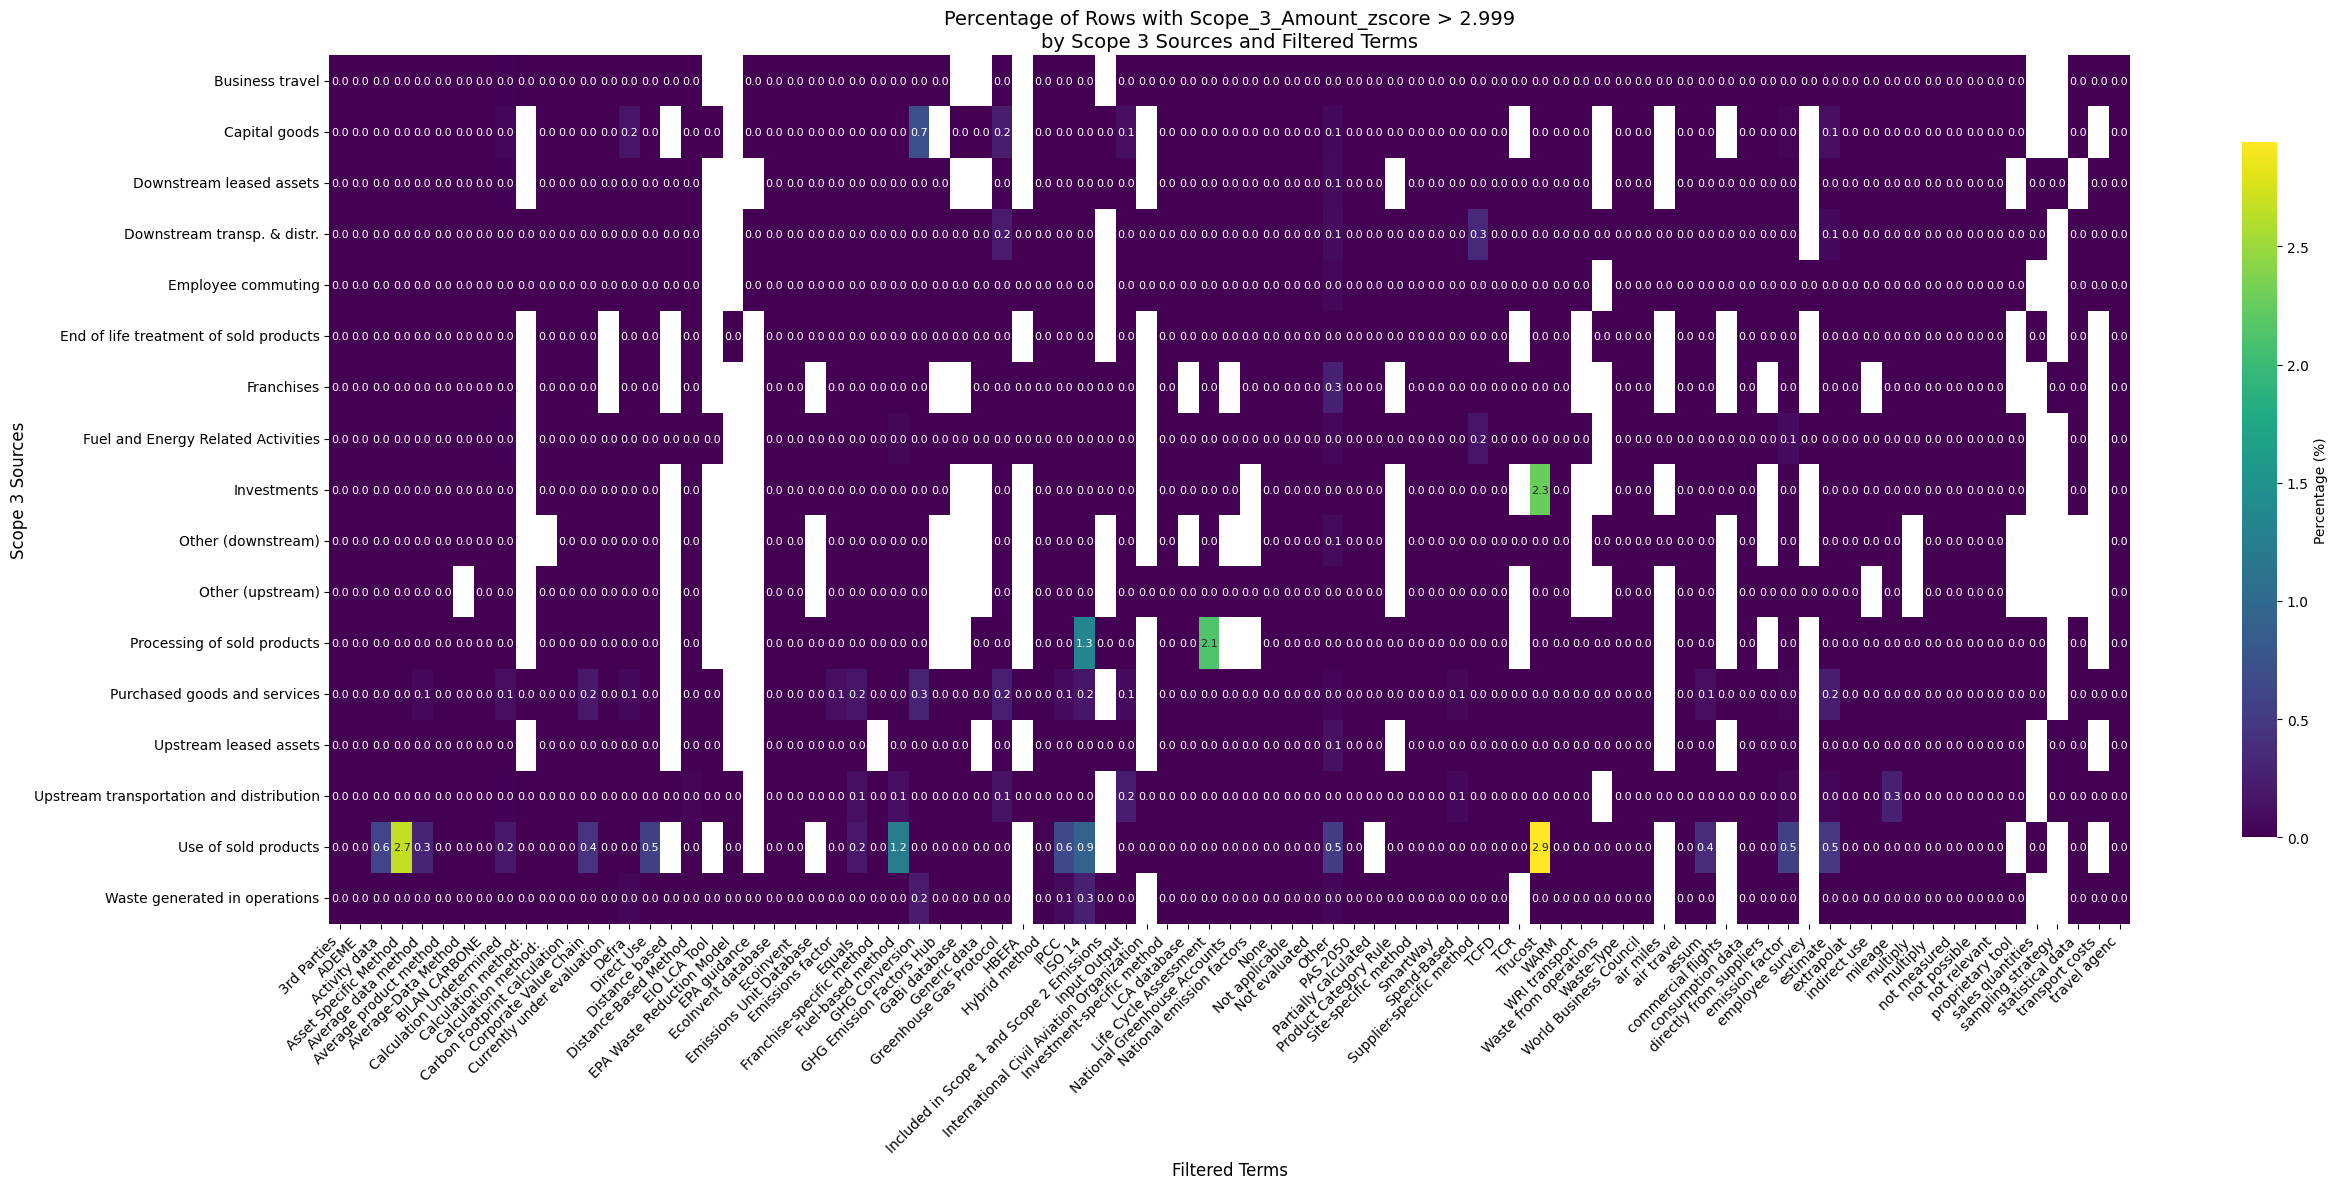

In [105]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Group by 'Scope 3 Sources' and 'Filtered_Terms'
grouped = Scope_3_df_exploded.groupby(['Scope 3 Sources', 'Filtered_Terms'])

# Calculate percentage of rows with Scope_3_Amount_zscore > 2.999 per group
percentage = grouped['Scope_3_Amount_zscore'].apply(
    lambda x: (x > 2.999).sum() / x.count() * 100 if x.count() > 0 else 0
).reset_index(name='Percentage')

# Create a pivot table for the heatmap: rows are Scope 3 Sources, columns are Filtered_Terms
pivot_table = percentage.pivot(index='Scope 3 Sources', columns='Filtered_Terms', values='Percentage')

# Rename specific y-axis labels to be more readable
pivot_table.rename(
    index={'Fuel-and-energy-related activities (not included in Scope 1 or 2)': 'Fuel and Energy Related Activities',
           'Downstream transportation and distribution': 'Downstream transp. & distr.',
           'Upstream transportaton and distribution': 'Upstream transp. & distr.'},
    inplace=True
)

# Set figure size and plot heatmap
plt.figure(figsize=(26, 12))
ax = sns.heatmap(
    pivot_table, 
    annot=True, 
    fmt=".1f", 
    cmap="viridis", 
    cbar_kws={'label': 'Percentage (%)', 'shrink': 0.8},  # Shrink color bar for better fit
    annot_kws={'size': 8}  # Reduce annotation font size for readability
)

# Set title and labels
plt.title("Percentage of Rows with Scope_3_Amount_zscore > 2.999\nby Scope 3 Sources and Filtered Terms", fontsize=14)
plt.ylabel("Scope 3 Sources", fontsize=12)
plt.xlabel("Filtered Terms", fontsize=12)

# Rotate x-axis labels to fit long names
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=10)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)

plt.tight_layout()
plt.show()


# Heatmap analysis

This heatmap highlights the complexity and inconsistency in how companies report Scope 3 emissions.

Across the dataset, 78 unique calculation methods were uncovered, ranging from formal frameworks like the GHG Protocol or DEFRA, to vague or non-standard labels like 'Not evaluated' or 'Sales quantities’.

Many of these informal entries lack clear boundaries or formulas, which makes it difficult to compare emissions across companies or sectors reliably.

Language barriers also posed a challenge as many method descriptions were in their native languages, further complicating automated parsing and normalization.

The heatmap below shows the prevalence of high z-score amounts by scope 3 type and calculation method on the x axis.

To help flag uncertainty, records with unclear or unrecognized methods were labeled as 'Calculation Undetermined', which you can see reflected in the heatmap.

Interestingly, certain methods—such as TruCost—were linked with a higher prevalence of statistical outliers, raising concerns about how underlying assumptions may influence reported totals.  

More data points would be needed, however, to draw definitive conclusions on the accuracy of any specific methods.

Overall, this analysis reinforces the idea that the choice of calculation method isn’t just a technical detail—it can shape the emissions figure itself, and by extension, affect the reliability of predictive models.


https://www.marketplace.spglobal.com/en/datasets/trucost-environmental-(46)

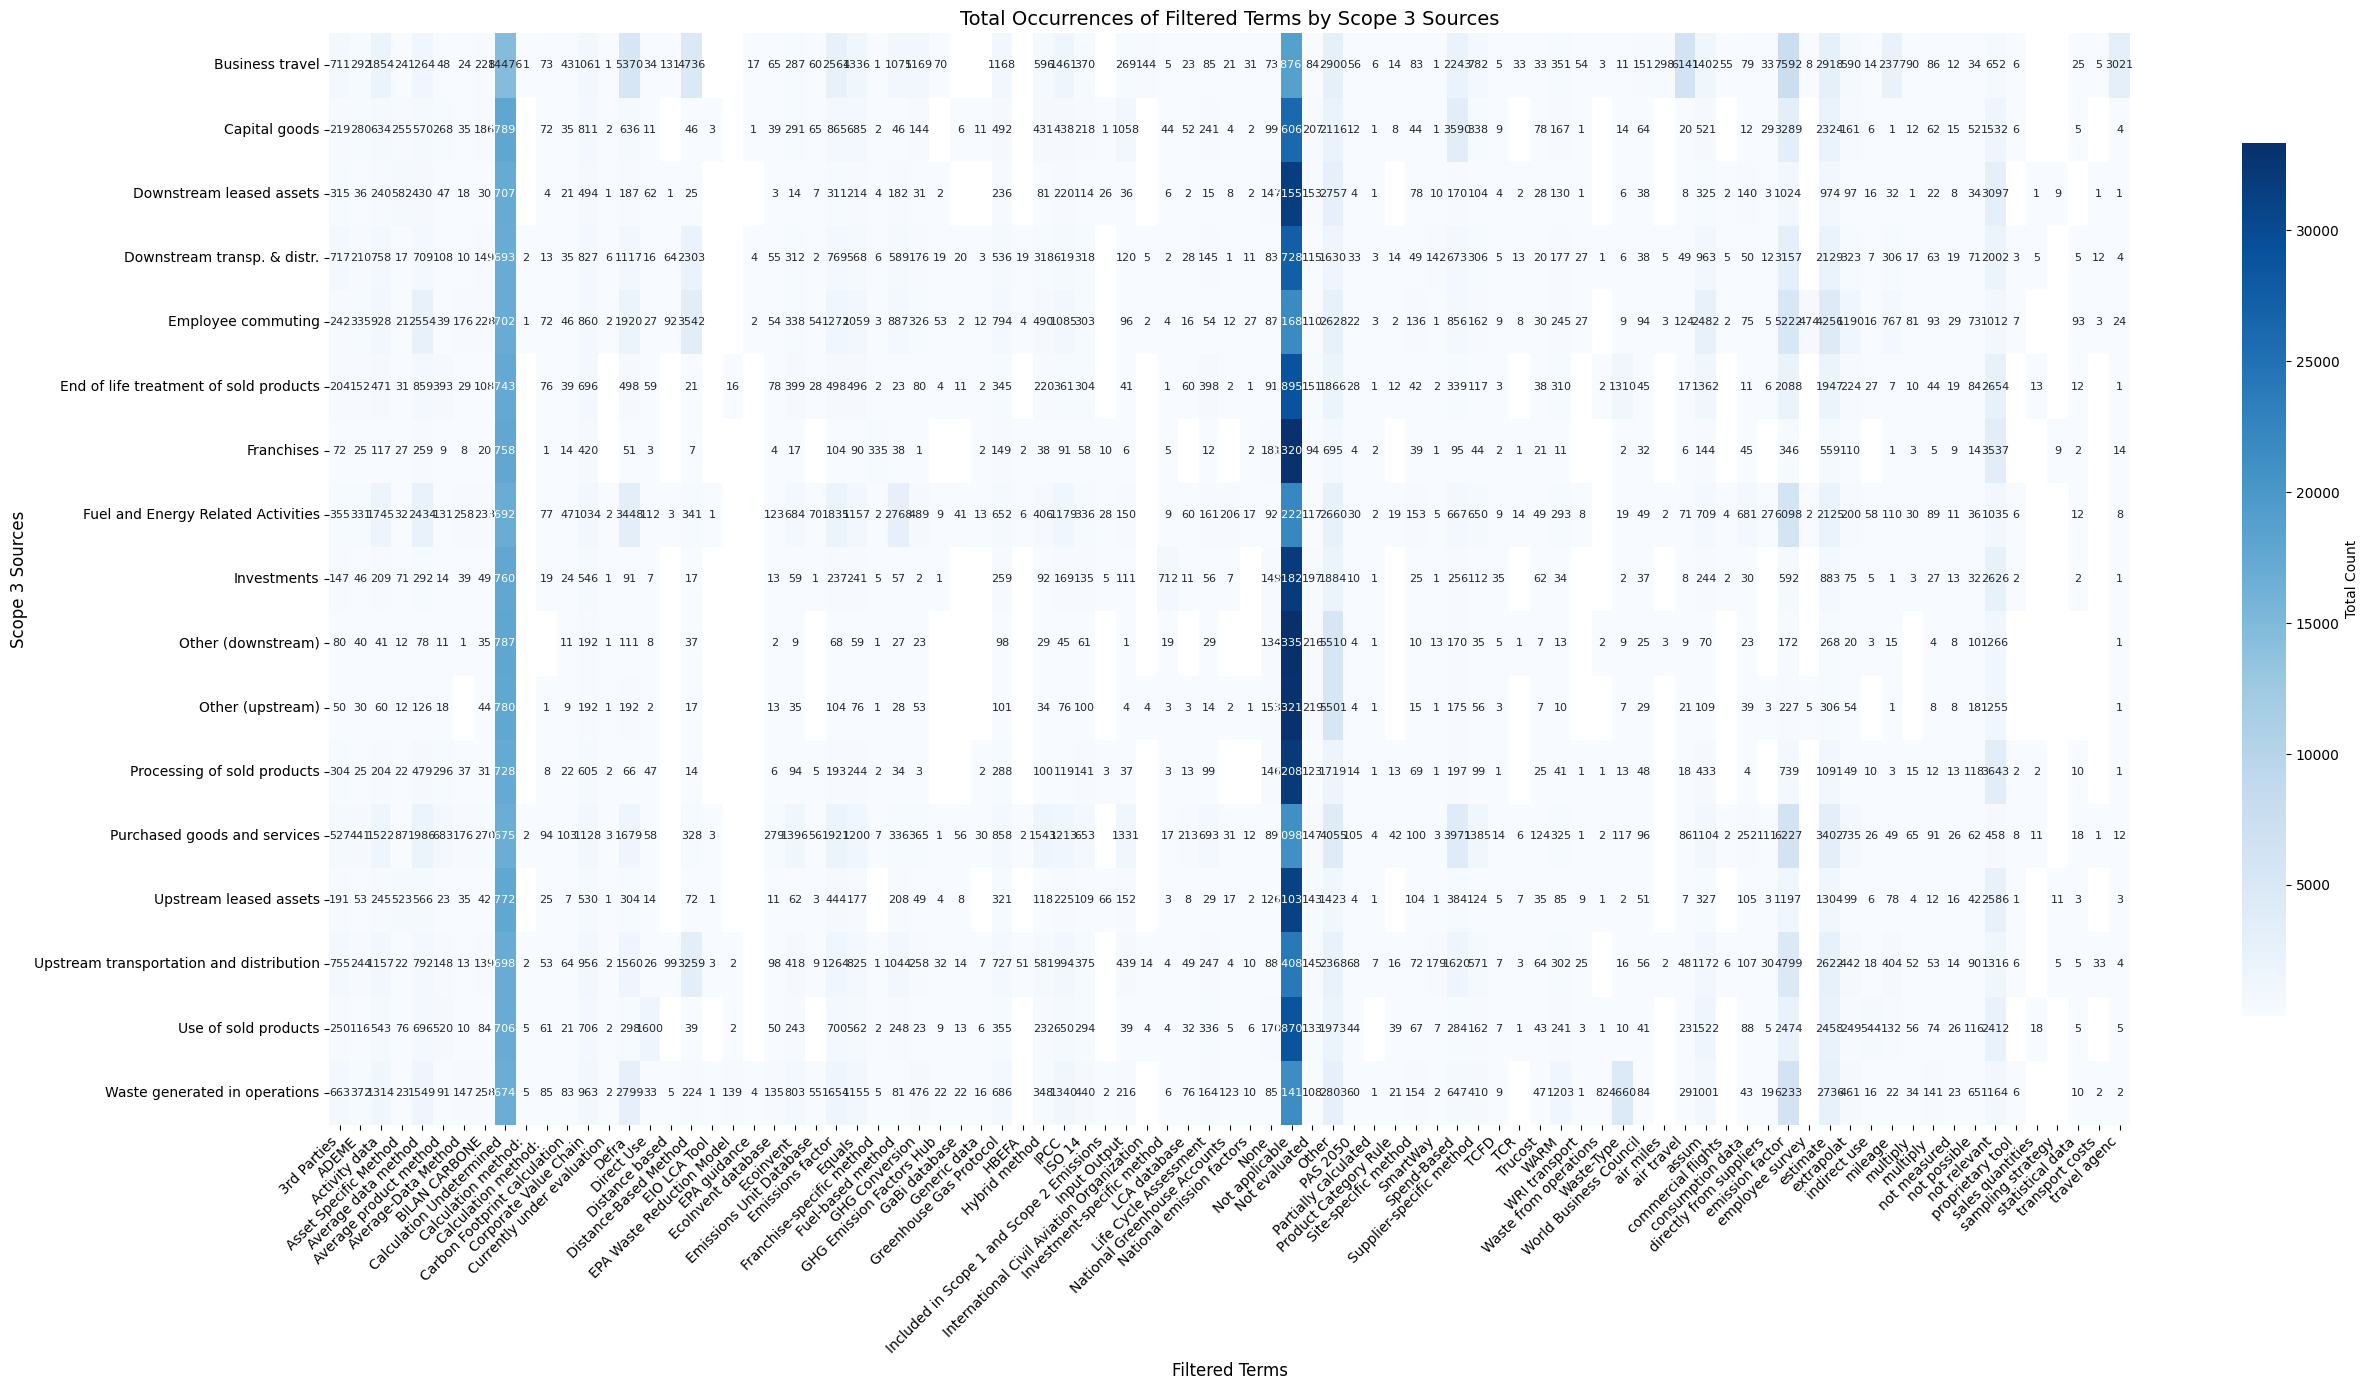

In [112]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Group by 'Scope 3 Sources' and 'Filtered_Terms' and count occurrences
total_counts = Scope_3_df_exploded.groupby(['Scope 3 Sources', 'Filtered_Terms']).size().reset_index(name='Total Count')

# Create a pivot table for the heatmap: rows are 'Scope 3 Sources', columns are 'Filtered_Terms', values are counts
pivot_table = total_counts.pivot(index='Scope 3 Sources', columns='Filtered_Terms', values='Total Count')

# Rename specific y-axis labels to be more readable
pivot_table.rename(
    index={
        'Fuel-and-energy-related activities (not included in Scope 1 or 2)': 'Fuel and Energy Related Activities',
        'Downstream transportation and distribution': 'Downstream transp. & distr.',
        'Upstream transportaton and distribution': 'Upstream transp. & distr.'
    },
    inplace=True
)

# Set figure size and plot heatmap
plt.figure(figsize=(26, 14))
ax = sns.heatmap(
    pivot_table, 
    annot=True,  # Show actual counts
    fmt="g",  # Format as integer values
    cmap="Blues",  # Use a more neutral colormap for clarity
    cbar_kws={'label': 'Total Count', 'shrink': 0.8},  # Shrink color bar for better fit
    annot_kws={'size': 8}  # Reduce annotation font size for readability
)

# Set title and labels
plt.title("Total Occurrences of Filtered Terms by Scope 3 Sources", fontsize=14)
plt.ylabel("Scope 3 Sources", fontsize=12)
plt.xlabel("Filtered Terms", fontsize=12)

# Rotate x-axis labels to fit long names
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=10)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)

plt.tight_layout()
plt.show()


# Clustering exploration

I attempted to do some clustering analysis below but adapting code from another notebook but did really get any significant results so I did not include this in the final presentation slide.

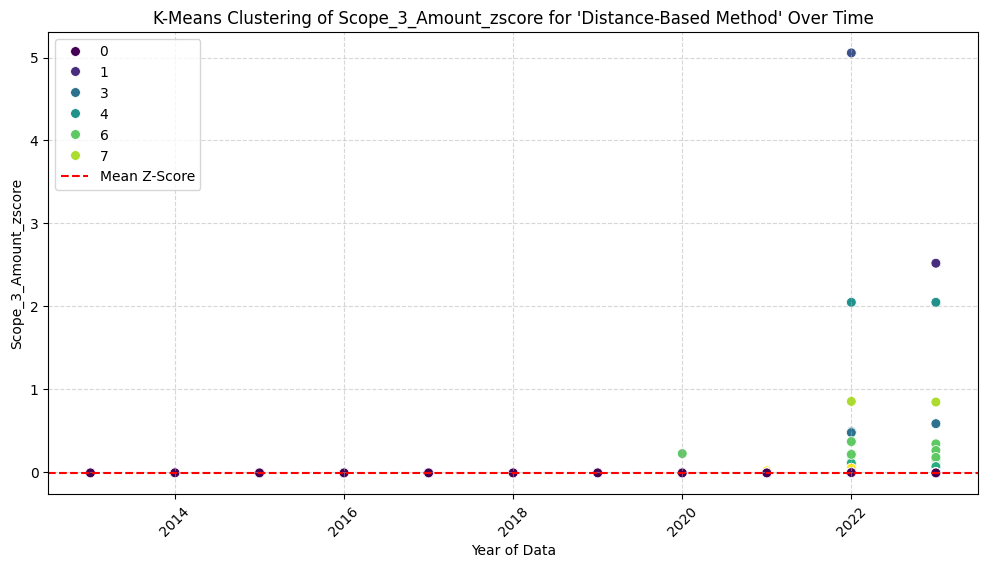

In [150]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Define the term for filtering
Term = 'Distance-Based Method'
#Term = 'Trucost'

#Filter Data for the Selected Term
filtered_df = Scope_3_df_exploded[Scope_3_df_exploded['Filtered_Terms'] == Term].copy()


filtered_df = filtered_df.dropna(subset=['Scope_3_Amount_zscore'])

# Convert 'Year of Data' to numeric for proper ordering
filtered_df['Year of Data'] = pd.to_numeric(filtered_df['Year of Data'], errors='coerce')

# Sort by Year to maintain chronological order
filtered_df = filtered_df.sort_values(by='Year of Data')

X = filtered_df[['Scope_3_Amount_zscore']].values  


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

k = 9  
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
filtered_df['Cluster'] = kmeans.fit_predict(X_scaled)

plt.figure(figsize=(12, 6))
sns.scatterplot(
    x=filtered_df['Year of Data'], 
    y=filtered_df['Scope_3_Amount_zscore'], 
    hue=filtered_df['Cluster'], 
    palette='viridis', 
    s=50
)

# Add a Mean Z-Score Line
plt.axhline(y=np.mean(filtered_df['Scope_3_Amount_zscore']), color='red', linestyle='dashed', label='Mean Z-Score')

#plt.ylim(-1, 5)  


plt.title(f"K-Means Clustering of Scope_3_Amount_zscore for '{Term}' Over Time")
plt.xlabel("Year of Data")
plt.ylabel("Scope_3_Amount_zscore")
plt.legend()
plt.xticks(rotation=45) 
plt.grid(True, linestyle="--", alpha=0.5)

plt.show()



# References

GHG Protocol. (n.d.). Scope 3 calculation guidance: Making corporate value chain accounting easier than ever. World Resources Institute. Retrieved April 29, 2025, from https://ghgprotocol.org/scope-3-calculation-guidance-2